### Attempting to run regressions from systematics values extracted geometrically or from Kitanidis et al on galaxy density


In [260]:
import pandas as pd
import numpy as np
import pickle
import healpy as hp
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [261]:
### Setting Healpy Information
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


Approximate resolution at NSIDE 256 is 0.23 deg


### Importing Galaxy Density Information

In [262]:
df_objects = pd.read_csv('../bricks_data/galaxy_catalogue.csv')


In [263]:
df_objects = df_objects.drop_duplicates()

df_objects.head()

,BrickID,RA,DEC,Target_type,Fitbits,Maskbits
0,120312,5.165116,-39.411469,2,1,0
1,120312,5.165771,-39.443575,3,1,0
2,120312,5.167412,-39.552630,2,1,0
3,120312,5.169102,-39.400914,3,1,0
4,120312,5.169548,-39.533226,3,1,0


In [264]:
# LRG

df_LRG = df_objects[df_objects["Target_type"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, counts), axis=1)
#print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

Number of LRGs in Sample: 4271038
[  1564   1574   1577 ... 757955 758427 758428]
Mean LRGs per Pixel: 14.987518115751318


,pixel_id,lrg
0,1564,2
1,1574,4
2,1577,1
3,1668,3
4,1669,2


In [265]:
# elg

df_ELG = df_objects[df_objects["Target_type"] == 2]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
#density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

Number of ELGs in Sample: 14963034
[  1564   1574   1577 ... 758427 758428 758430]
Mean ELGs per Pixel: 49.39322037255271
[[  1564      4]
 [  1574      2]
 [  1577      7]
 ...
 [758427      6]
 [758428     11]
 [758430      6]]
   pixel_id  elg
0      1564    4
1      1574    2
2      1577    7
3      1668   13
4      1669   16


In [266]:
df_QSO = df_objects[df_objects["Target_type"] == 3]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
#density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

Number of QSOs in Sample: 20596063
[  1562   1563   1564 ... 758427 758428 758430]
Mean QSOs per Pixel: 67.3102550108338
[[  1562      2]
 [  1563      4]
 [  1564      8]
 ...
 [758427      8]
 [758428      6]
 [758430      4]]
   pixel_id  qso
0      1562    2
1      1563    4
2      1564    8
3      1574    6
4      1577    7


In [267]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

pixel_id        0
lrg         24826
elg          6862
qso          3812
dtype: int64
(284973, 2) (302937, 2) (305987, 2) (309799, 4)


In [268]:
# Dropping all pixels where I do not have counts for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())

pixel_id    0
lrg         0
elg         0
qso         0
dtype: int64


In [269]:
print( df.shape)


(282196, 4)


### Importing the Systematics Values and Appending them to the df.


#### Stellar Density

In [270]:
df_stellar = pd.read_csv('../bricks_data/stellar_catalogue.csv')
df_stellar.shape


(4524152, 5)

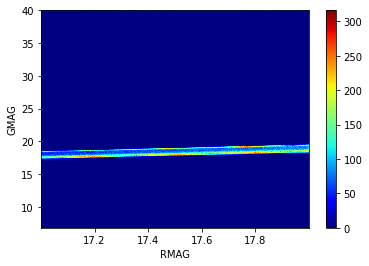

In [271]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [272]:
# REMOVING OUTLIERS
print(df_stellar.shape)

(4524152, 5)


In [273]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [274]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30) ]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30) ]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4) ]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4) ]
print(df_stellar.shape)


(4357535, 7)


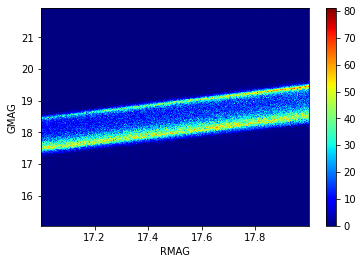

In [275]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [276]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=1000, labels=False)
df_stellar['percent_RMAG'].value_counts()


573    4373
316    4373
759    4373
394    4372
507    4372
       ... 
754    4342
760    4342
368    4342
351    4342
653    4341
Name: percent_RMAG, Length: 1000, dtype: int64

In [277]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [278]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=1000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=1000, labels=False)
df_stellar.shape

(4357535, 12)

In [279]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [280]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [281]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

(4357535, 12)
(4325356, 12)


(4306587, 12)

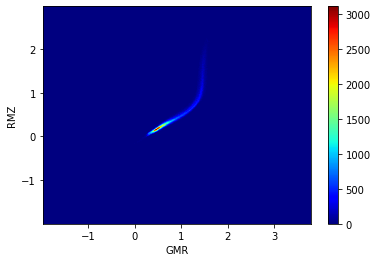

In [282]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [283]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

Number of stellars in Sample: 4306587
[  1562   1574   1577 ... 757954 757955 758427]
Mean stellars per Pixel: 15.356262368735402
[[  1562      1]
 [  1574      3]
 [  1577      1]
 ...
 [757954      7]
 [757955      4]
 [758427      2]]
   pixel_id  stellar
0      1562        1
1      1574        3
2      1577        1
3      1673        4
4      1675       13
pixel_id    0
stellar     0
dtype: int64


In [284]:
df = df.merge(df_stellar, how='inner', on='pixel_id')
print(df.isna().sum())
df.shape

pixel_id    0
lrg         0
elg         0
qso         0
stellar     0
dtype: int64


(268108, 5)

#### EBV Extraction

In [285]:
from astropy.coordinates import SkyCoord, Latitude, Longitude
from dustmaps.sfd import SFDQuery


In [286]:
## Getting the centers of each pixel in my corpus as RaDec

pixels_ids = df["pixel_id"].to_numpy()
print(pixels_ids)
subpixel_coords = hp.pix2ang(NSIDE,pixels_ids, lonlat=True)
ra_ebv= subpixel_coords[0]
dec_ebv = subpixel_coords[1]

[  1574   1577   1673 ... 757954 757955 758427]


In [287]:
#Querying their position on the SFD dustmap
sfd = SFDQuery()
coords = SkyCoord(ra_ebv, dec_ebv, frame='icrs', unit='deg')
ebv = sfd(coords)

df["EBV"] = ebv

In [288]:
df.EBV.describe()
df.head()

,pixel_id,lrg,elg,qso,stellar,EBV
0,1574,4.0,2.0,6.0,3,0.135581
1,1577,1.0,7.0,7.0,1,0.090038
2,1673,1.0,8.0,22.0,4,0.150272
3,1675,21.0,45.0,84.0,13,0.231753
4,1676,1.0,10.0,14.0,4,0.233339


In [289]:
df.lrg = df.lrg.astype(int)
df.elg = df.elg.astype(int)
df.qso = df.qso.astype(int)
df.dtypes

pixel_id      int64
lrg           int64
elg           int64
qso           int64
stellar       int64
EBV         float32
dtype: object

#### Kitanidis Systematics Values

In [290]:
with open('../bricks_data/pixel2systematics_kitanidis.pickle', 'rb') as f:
    kitanidis_dict = pickle.load(f)
    f.close()

print(len(kitanidis_dict.keys()))

165618


In [291]:
pixel_keys = kitanidis_dict.keys()

sys_list = []
for key in pixel_keys:
    ind_sys_list = kitanidis_dict[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_kit = pd.DataFrame(sys_list, columns=['airmass',
'fwhm',
'ccdskysb_g',
'ccdskysb_r',
'ccdskysb_z',
'exptime_g',
'exptime_r',
'exptime_z',
'meansky_g',
'meansky_r',
'meansky_z',
'galdepth_g',
'galdepth_r',
'galdepth_z', 'pixel_id'])


In [292]:
# Remove columns where values are zero
df_sys_kit.describe()

print(df_sys_kit.shape)
df_sys_kit = df_sys_kit.drop(index=[99852,111780])
print(df_sys_kit.shape)

(165618, 15)
(165616, 15)


In [293]:
df_kitanidis = df.merge(df_sys_kit, how='inner', on='pixel_id')
print(df_kitanidis.isna().sum())
df_kitanidis.dropna(axis=0, inplace=True)

df_kitanidis.head()


pixel_id       0
lrg            0
elg            0
qso            0
stellar        0
EBV            0
airmass        0
fwhm           0
ccdskysb_g    44
ccdskysb_r    31
ccdskysb_z     6
exptime_g      0
exptime_r      0
exptime_z      0
meansky_g      0
meansky_r      0
meansky_z      0
galdepth_g     0
galdepth_r     0
galdepth_z     0
dtype: int64


,pixel_id,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z
0,1675,21,45,84,13,0.231753,1.718913,4.012114,22.476277,21.391496,19.028658,206.4,238.800000,204.665230,0.311778,5.562486,2.361189,22.510944,22.103737,22.434057
1,1677,16,44,82,8,0.198980,1.718603,4.402495,23.463299,21.424381,19.190657,180.0,230.000000,186.239429,0.291843,3.932022,2.004705,23.508274,22.167623,22.452290
2,1678,22,45,94,14,0.178034,1.712459,4.023360,22.447087,21.395767,19.164751,207.8,238.690000,200.886003,0.294317,4.624029,2.046824,22.614710,22.139793,22.452860
3,1689,16,34,71,13,0.131707,1.735196,4.390453,23.346248,22.741932,18.669951,250.0,173.886980,204.784836,0.311296,0.720955,3.505871,23.638793,23.095866,22.145799
4,1691,23,49,85,20,0.101732,1.766976,4.470975,23.345020,22.752506,18.589021,250.0,172.070999,216.971573,0.310873,0.713051,5.224869,23.662212,23.019058,22.088499


In [294]:
print(df_kitanidis.isna().sum())


pixel_id      0
lrg           0
elg           0
qso           0
stellar       0
EBV           0
airmass       0
fwhm          0
ccdskysb_g    0
ccdskysb_r    0
ccdskysb_z    0
exptime_g     0
exptime_r     0
exptime_z     0
meansky_g     0
meansky_r     0
meansky_z     0
galdepth_g    0
galdepth_r    0
galdepth_z    0
dtype: int64


#### Geometric Systematics Values, not involving edge pixels

In [295]:
with open('../bricks_data/pixel2systematics_geometric_non_inclusive.pickle', 'rb') as f:
    geometric_dict_no = pickle.load(f)
    f.close()

print(len(geometric_dict_no.keys()))

446042


In [296]:
sys_list = []
for key in geometric_dict_no.keys():
    ind_sys_list = geometric_dict_no[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_geo_no = pd.DataFrame(sys_list, columns=['airmass',
'fwhm',
'ccdskysb_g',
'ccdskysb_r',
'ccdskysb_z',
'exptime_g',
'exptime_r',
'exptime_z',
'meansky_g',
'meansky_r',
'meansky_z',
'galdepth_g',
'galdepth_r',
'galdepth_z', 'pixel_id'])


In [297]:
df_geometric_no = df.merge(df_sys_geo_no, how='inner', on='pixel_id')
print(df_geometric_no.isna().sum())
df_geometric_no.dropna(axis=0, inplace=True)
print(df_geometric_no.isna().sum())

pixel_id       0
lrg            0
elg            0
qso            0
stellar        0
EBV            0
airmass        0
fwhm           0
ccdskysb_g    38
ccdskysb_r    29
ccdskysb_z     2
exptime_g      0
exptime_r      0
exptime_z      0
meansky_g      0
meansky_r      0
meansky_z      0
galdepth_g     0
galdepth_r     0
galdepth_z     0
dtype: int64
pixel_id      0
lrg           0
elg           0
qso           0
stellar       0
EBV           0
airmass       0
fwhm          0
ccdskysb_g    0
ccdskysb_r    0
ccdskysb_z    0
exptime_g     0
exptime_r     0
exptime_z     0
meansky_g     0
meansky_r     0
meansky_z     0
galdepth_g    0
galdepth_r    0
galdepth_z    0
dtype: int64


In [129]:
#df_geometric_no.drop(columns=['pixel_id'], inplace=True)

In [124]:
print(df_geometric_no.describe())

            pixel_id            lrg            elg            qso  \
count  267226.000000  267226.000000  267226.000000  267226.000000   
mean   346071.952115      15.794111      55.094819      75.864770   
std    202938.283807      12.368389      37.172325      50.538023   
min      1673.000000       1.000000       1.000000       1.000000   
25%    190644.250000       6.000000      23.000000      32.000000   
50%    327698.000000      14.000000      51.000000      70.000000   
75%    472447.500000      23.000000      83.000000     113.000000   
max    757954.000000     529.000000    1840.000000    1266.000000   

             stellar            EBV        airmass           fwhm  \
count  267226.000000  267226.000000  267226.000000  267226.000000   
mean       15.955191       0.042766       1.363079       4.412227   
std        18.903334       0.032873       0.255462       0.977313   
min         1.000000       0.000583       1.000179       2.570826   
25%         5.000000       0.0202

In [298]:
df_geometric = df_geometric_no.drop(index=[38700])


In [ ]:
"""
df_kitanidis['lrg_density'] = (df_kitanidis.lrg.mean()/df_kitanidis.lrg) - 1
df_kitanidis['elg_density'] = (df_kitanidis.elg.mean()/df_kitanidis.elg) - 1
df_kitanidis['qso_density'] = (df_kitanidis.qso.mean()/df_kitanidis.qso) - 1

df_kitanidis.describe()

In [ ]:
df_geometric = df_geometric_no.drop(index=[38700])
df_geometric['lrg_density'] = (df_geometric.lrg.mean()/df_geometric.lrg) - 1
df_geometric['elg_density'] = (df_geometric.elg.mean()/df_geometric.elg) - 1
df_geometric['qso_density'] = (df_geometric.qso.mean()/df_geometric.qso) - 1
df_geometric.describe()d \
dd \
d"""

In [ ]:
print(df_kitanidis.shape)
print(df_geometric.shape)

In [300]:
df_geometric.to_csv('../bricks_data/dataset_geometric.csv', index=False)
df_kitanidis.to_csv('../bricks_data/dataset_kitanidis.csv', index=False)


### Clean corpus to only retain those pixels present in both for comparability

In [184]:
print(len(df_geometric.pixel_id.unique()))

m_kit = df_kitanidis.pixel_id.isin(df_geometric.pixel_id)
m_geo = df_geometric.pixel_id.isin(df_kitanidis.pixel_id)
df_geometric = df_geometric[m_geo]
df_kitanidis = df_kitanidis[m_kit]
print(len(df_geometric.pixel_id.unique()))

267225
165142


In [185]:
print(df_kitanidis.shape)
print(df_geometric.shape)


for column in df_kitanidis.columns:
    print("Systematic:", column)
    print()
    print("Kitanidis")
    print("Mean", df_kitanidis[column].mean())
    print("Median", df_kitanidis[column].mean())
    print("STD",df_kitanidis[column].std())
    print("MIN",df_kitanidis[column].min())
    print("MAX",df_kitanidis[column].max())
    print()
    print("Geometric")
    print("Mean", df_geometric[column].mean())
    print("Median", df_geometric[column].mean())
    print("STD",df_geometric[column].std())
    print("MIN",df_geometric[column].min())
    print("MAX",df_geometric[column].max())
    print()
    print("======================")
    print()


(165142, 20)
(165142, 20)
Systematic: pixel_id

Kitanidis
Mean 352325.6939300723
Median 352325.6939300723
STD 199002.1035359759
MIN 1675
MAX 757472

Geometric
Mean 352325.6939300723
Median 352325.6939300723
STD 199002.1035359759
MIN 1675
MAX 757472


Systematic: lrg

Kitanidis
Mean 22.125855324508606
Median 22.125855324508606
STD 11.536780576809349
MIN 1
MAX 529

Geometric
Mean 22.125855324508606
Median 22.125855324508606
STD 11.536780576809349
MIN 1
MAX 529


Systematic: elg

Kitanidis
Mean 77.34609608700391
Median 77.34609608700391
STD 29.283416319747833
MIN 6
MAX 1840

Geometric
Mean 77.34609608700391
Median 77.34609608700391
STD 29.283416319747833
MIN 6
MAX 1840


Systematic: qso

Kitanidis
Mean 106.55710237250366
Median 106.55710237250366
STD 39.26077481403487
MIN 4
MAX 1266

Geometric
Mean 106.55710237250366
Median 106.55710237250366
STD 39.26077481403487
MIN 4
MAX 1266


Systematic: stellar

Kitanidis
Mean 22.03334100350002
Median 22.03334100350002
STD 21.284281369709916
MIN 1
M

### Running the Regressions

#### 1. Kitanidis

In [186]:
df_kitanidis.head()
df_kitanidis_reg = df_kitanidis.drop(columns=['pixel_id'])
df_kitanidis_reg.head()

,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z
0,21,45,84,13,0.231753,1.718913,4.012114,22.476277,21.391496,19.028658,206.4,238.800000,204.665230,0.311778,5.562486,2.361189,22.510944,22.103737,22.434057
1,16,44,82,8,0.198980,1.718603,4.402495,23.463299,21.424381,19.190657,180.0,230.000000,186.239429,0.291843,3.932022,2.004705,23.508274,22.167623,22.452290
2,22,45,94,14,0.178034,1.712459,4.023360,22.447087,21.395767,19.164751,207.8,238.690000,200.886003,0.294317,4.624029,2.046824,22.614710,22.139793,22.452860
3,16,34,71,13,0.131707,1.735196,4.390453,23.346248,22.741932,18.669951,250.0,173.886980,204.784836,0.311296,0.720955,3.505871,23.638793,23.095866,22.145799
4,23,49,85,20,0.101732,1.766976,4.470975,23.345020,22.752506,18.589021,250.0,172.070999,216.971573,0.310873,0.713051,5.224869,23.662212,23.019058,22.088499


In [187]:
y_lrg = df_kitanidis_reg['lrg']#.to_numpy(copy=True)
y_elg = df_kitanidis_reg['elg']#.to_numpy(copy=True)
y_qso = df_kitanidis_reg['qso']#.to_numpy(copy=True)

X = df_kitanidis_reg.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)

In [188]:
print(len(y_lrg))
print(len(X))

165142
165142


In [189]:


ols_lrg_kitanidis = sm.OLS(y_lrg,X).fit()
print(ols_lrg_kitanidis.summary())

print()
ols_elg_kitanidis = sm.OLS(y_elg,X).fit()
print(ols_elg_kitanidis.summary())
print()
ols_qso_kitanidis = sm.OLS(y_qso,X).fit()
print(ols_qso_kitanidis.summary())

                            OLS Regression Results                            
Dep. Variable:                    lrg   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     863.9
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:28:23   Log-Likelihood:            -6.3195e+05
No. Observations:              165142   AIC:                         1.264e+06
Df Residuals:                  165126   BIC:                         1.264e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
stellar        0.1558      0.001    109.475      0.0

#### 2. Geometric

In [190]:
df_geometric.head()
df_geometric_reg = df_geometric.drop(columns=['pixel_id'])
df_geometric_reg.head()

,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z
1,21,45,84,13,0.231753,1.752745,4.333361,23.412788,21.349841,18.934986,215.0,240.000000,160.604004,0.324769,5.615912,2.599613,23.448900,22.083221,22.318394
3,16,44,82,8,0.198980,1.743200,4.533583,23.463299,21.424380,19.140076,180.0,230.000000,176.439677,0.291843,3.932022,2.134053,23.508274,22.167623,22.373904
4,22,45,94,14,0.178034,1.725647,4.229492,23.385620,21.436897,19.110413,215.0,237.916667,213.606003,0.305991,4.657650,2.125587,23.555042,22.131536,22.489397
7,16,34,71,13,0.131707,1.754390,4.649734,23.346163,22.744095,18.603508,250.0,173.535492,160.437988,0.310965,0.719607,3.963446,23.634092,23.083635,22.012065
8,23,49,85,20,0.101732,1.786545,4.244760,23.345020,22.752506,18.406242,250.0,172.070999,220.105011,0.310873,0.713051,5.868712,23.662212,23.019058,21.914766


In [191]:
y_lrg = df_geometric_reg['lrg']#.to_numpy(copy=True)
y_elg = df_geometric_reg['elg']#.to_numpy(copy=True)
y_qso = df_geometric_reg['qso']#.to_numpy(copy=True)

X = df_geometric_reg.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)

In [192]:
print(len(y_lrg))
print(len(X))

165142
165142


In [193]:
ols_lrg_geometric = sm.OLS(y_lrg,X).fit()
print(ols_lrg_geometric.summary())
print()
ols_elg_geometric = sm.OLS(y_elg,X).fit()
print(ols_elg_geometric.summary())
print()
ols_qso_geometric = sm.OLS(y_qso,X).fit()
print(ols_qso_geometric.summary())


                            OLS Regression Results                            
Dep. Variable:                    lrg   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     859.8
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:29:04   Log-Likelihood:            -6.3198e+05
No. Observations:              165142   AIC:                         1.264e+06
Df Residuals:                  165126   BIC:                         1.264e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
stellar        0.1551      0.001    109.094      0.0

0.0 180.0 -180.0 180.0


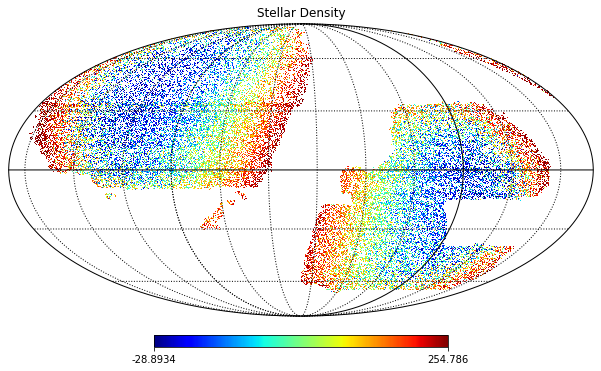

In [174]:
m = np.zeros(NPIX)

m[df_kitanidis.pixel_id.unique()] = df_kitanidis.stellar.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="Stellar Density", norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


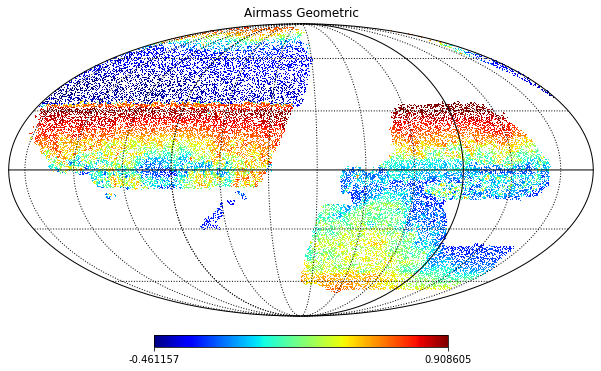

In [194]:
m = np.zeros(NPIX)

m[df_geometric.pixel_id.unique()] = df_geometric.airmass.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="Airmass Geometric", norm='hist',cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


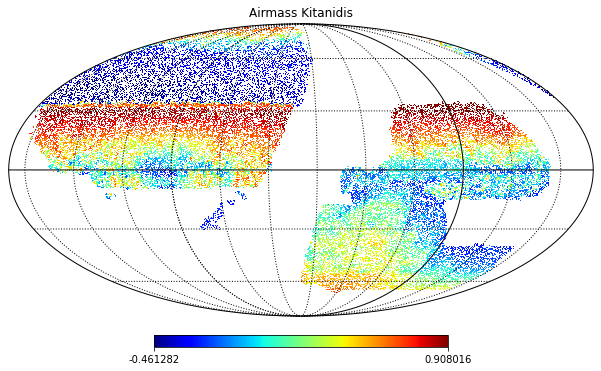

In [196]:
m = np.zeros(NPIX)

m[df_kitanidis.pixel_id.unique()] = df_kitanidis.airmass.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="Airmass Kitanidis", norm='hist',cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()



0.0 180.0 -180.0 180.0


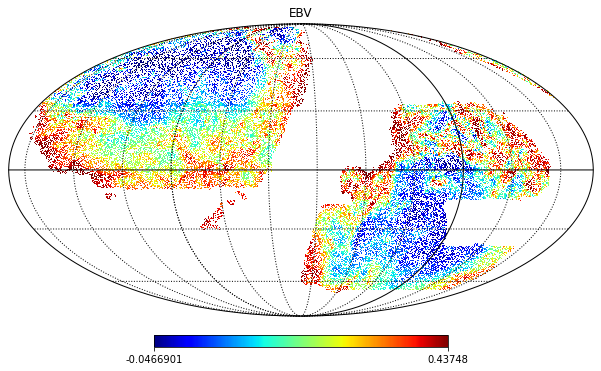

In [198]:
m = np.zeros(NPIX)

m[df_kitanidis.pixel_id.unique()] = df_kitanidis.EBV.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="EBV",cmap="jet", norm='hist', notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


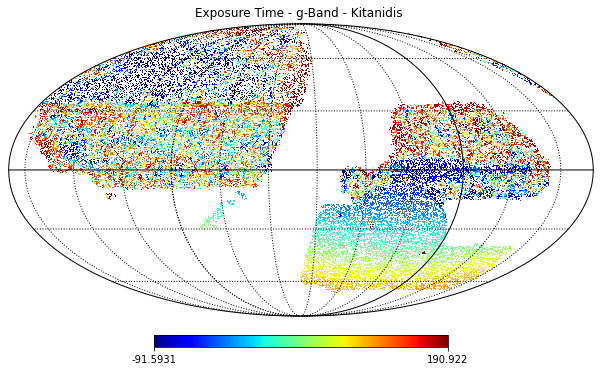

In [200]:
m = np.zeros(NPIX)

m[df_kitanidis.pixel_id.unique()] = df_kitanidis.exptime_g.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="Exposure Time - g-Band - Kitanidis ", norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

In [221]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler(with_mean=0)


In [223]:
"""
df_kitanidis['lrg_density'] = scaler.fit_transform(df_kitanidis.lrg.to_numpy().reshape(-1, 1))
df_kitanidis['elg_density'] = scaler.fit_transform(df_kitanidis.elg.to_numpy().reshape(-1, 1))
df_kitanidis['qso_density'] = scaler.fit_transform(df_kitanidis.qso.to_numpy().reshape(-1, 1))

"""
df_kitanidis['lrg_density'] = (df_kitanidis.lrg.mean()/df_kitanidis.lrg) - 1
df_kitanidis['elg_density'] = (df_kitanidis.elg.mean()/df_kitanidis.elg) - 1
df_kitanidis['qso_density'] = (df_kitanidis.qso.mean()/df_kitanidis.qso) - 1

df_kitanidis.describe()

,pixel_id,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,...,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z,lrg_density,percentile,elg_density,qso_density
count,165142.000000,165142.000000,165142.000000,165142.000000,165142.000000,165142.000000,165142.000000,165142.000000,165142.000000,165142.000000,...,1.651420e+05,1.651420e+05,1.651420e+05,165142.000000,165142.000000,165142.000000,165142.000000,165142.000000,165142.000000,165142.000000
mean,352325.693930,22.125855,77.346096,106.557102,22.033341,0.042343,1.368838,4.430217,23.466385,22.581841,...,2.742310e+07,9.766971e+07,8.397219e+08,23.682950,23.175061,22.222407,0.279804,6.999994,0.150185,0.142331
std,199002.103536,11.536781,29.283416,39.260775,21.284281,0.032462,0.254479,0.934621,0.225308,0.250390,...,8.903723e+07,5.931245e+08,3.121924e+09,0.319674,0.337634,0.271834,0.789242,4.320528,0.462860,0.438386
min,1675.000000,1.000000,6.000000,4.000000,1.000000,0.001322,0.629248,2.646359,7.493428,7.192216,...,4.402534e-02,9.882516e-02,7.600524e-01,7.619181,7.451326,12.358440,-0.958174,0.000000,-0.957964,-0.915832
25%,202255.500000,14.000000,55.000000,76.000000,9.000000,0.020291,1.195955,4.121173,23.391222,22.479573,...,1.157750e-01,2.667451e-01,2.128548e+00,23.527352,22.994152,22.165216,-0.209791,3.000000,-0.194311,-0.198819
50%,334694.500000,20.000000,75.000000,102.000000,15.000000,0.033253,1.282909,4.436571,23.491618,22.607598,...,1.374394e-01,3.296116e-01,2.614753e+00,23.749869,23.241629,22.278710,0.106293,7.000000,0.031281,0.044677
75%,474730.250000,28.000000,96.000000,133.000000,26.000000,0.053707,1.508699,4.711789,23.575267,22.714568,...,2.713954e-01,8.208219e-01,3.492556e+00,23.874449,23.360690,22.367354,0.580418,11.000000,0.406293,0.402067
max,757472.000000,529.000000,1840.000000,1266.000000,289.000000,0.854514,2.352400,89.787219,24.240829,23.604935,...,2.416318e+09,2.051819e+11,6.475716e+10,24.564820,23.981908,28.303753,21.125855,14.000000,11.891016,25.639276


In [228]:
df_geometric = df_geometric_no.drop(index=[38700])
df_geometric['lrg_density'] = (df_geometric.lrg.mean()/df_geometric.lrg) - 1
df_geometric['elg_density'] = (df_geometric.elg.mean()/df_geometric.elg) - 1
df_geometric['qso_density'] = (df_geometric.qso.mean()/df_geometric.qso) - 1
df_geometric.describe()

,pixel_id,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,...,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z,lrg_density,elg_density,qso_density
count,267225.000000,267225.000000,267225.000000,267225.000000,267225.000000,267225.000000,267225.000000,267225.000000,267225.000000,267225.000000,...,267225.000000,2.672250e+05,2.672250e+05,2.672250e+05,267225.000000,267225.000000,267225.000000,267225.000000,267225.000000,267225.000000
mean,346072.822172,15.794155,55.094898,75.864960,15.955105,0.042766,1.363080,4.412232,23.468424,22.586086,...,113.597250,2.776171e+07,9.768095e+07,8.537282e+08,23.679761,23.169562,22.225515,1.496829,1.480814,1.409007
std,202938.165119,12.368391,37.172373,50.538022,18.903317,0.032873,0.255462,0.977312,0.179025,0.222662,...,31.064483,9.617436e+07,3.278314e+08,3.361100e+09,0.300391,0.329497,0.262758,3.427050,4.749180,4.688214
min,1673.000000,1.000000,1.000000,1.000000,1.000000,0.000583,1.000179,2.570826,18.267529,18.225866,...,5.103000,5.686485e-02,1.504735e-01,8.513426e-01,18.361883,16.510733,18.837189,-0.970143,-0.970057,-0.940075
25%,190645.000000,6.000000,23.000000,32.000000,5.000000,0.020218,1.190310,4.083220,23.387777,22.475899,...,90.000000,1.143003e-01,2.621360e-01,2.071340e+00,23.517888,22.966670,22.163933,-0.313298,-0.336206,-0.328629
50%,327699.000000,14.000000,51.000000,70.000000,10.000000,0.033591,1.277700,4.419159,23.491414,22.609411,...,102.000000,1.366737e-01,3.260445e-01,2.544922e+00,23.743640,23.236677,22.285126,0.128154,0.080292,0.083785
75%,472448.000000,23.000000,83.000000,113.000000,19.000000,0.054493,1.499369,4.703477,23.577220,22.724139,...,133.000000,2.638937e-01,7.712899e-01,3.377734e+00,23.880009,23.363157,22.377394,1.632359,1.395430,1.370780
max,757954.000000,529.000000,1840.000000,1266.000000,289.000000,0.854514,2.385126,93.586111,24.377570,23.802411,...,328.421053,5.202762e+09,9.249949e+09,9.433031e+10,24.705928,24.181324,27.191251,14.794155,54.094898,74.864960


In [229]:
df_geometric_no.shape

(267226, 20)

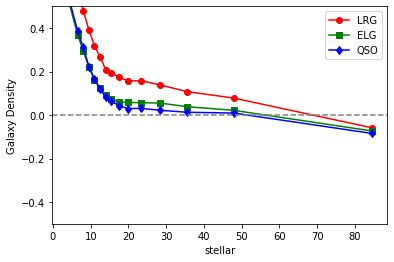

In [233]:

df_kitanidis['percentile'] = pd.qcut(df_kitanidis[x_label], q=15, labels=False, duplicates='drop')
grouped = df_kitanidis.groupby('percentile')
x = grouped[x_label].mean()
lrg = grouped['lrg_density'].mean()
elg = grouped['elg_density'].mean()
qso = grouped['qso_density'].mean()

plt.plot(x,lrg, c='red', marker='o', label="LRG")
plt.plot(x,elg, c='green', marker='s', label="ELG")
plt.plot(x,qso, c='blue', marker='d', label="QSO")
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylim([-0.5,0.5])
plt.xlabel(x_label)
plt.ylabel("Galaxy Density")
plt.legend()
plt.show()

In [1]:
x_label = 'EBV'

df_geometric['percentile'] = pd.qcut(df_geometric[x_label], q=15, labels=False, duplicates='drop')
grouped = df_geometric.groupby('percentile')
x = grouped[x_label].mean()
lrg = grouped['lrg_density'].mean()
elg = grouped['elg_density'].mean()
qso = grouped['qso_density'].mean()

plt.plot(x,lrg, c='red', marker='o', label="LRG")
plt.plot(x,elg, c='green', marker='s', label="ELG")
plt.plot(x,qso, c='blue', marker='d', label="QSO")
plt.axhline(y=0, color='gray', linestyle='--')
#plt.ylim([-1,1])
plt.xlabel(x_label)
plt.ylabel("Galaxy Density")
plt.legend()
plt.show()


NameError: name 'pd' is not defined

### Running the Regressions Again, this time with full sample for Geometric

#### 1. Kitanidis

In [251]:
df_kitanidis.head()
df_kitanidis_reg = df_kitanidis.drop(columns=['pixel_id'])
df_kitanidis_reg.head()

,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,...,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z,lrg_density,percentile,elg_density,qso_density
0,21,45,84,13,0.231753,1.718913,4.012114,22.476277,21.391496,19.028658,...,0.311778,5.562486,2.361189,22.510944,22.103737,22.434057,0.053612,5,0.718802,0.268537
1,16,44,82,8,0.198980,1.718603,4.402495,23.463299,21.424381,19.190657,...,0.291843,3.932022,2.004705,23.508274,22.167623,22.452290,0.382866,2,0.757866,0.299477
2,22,45,94,14,0.178034,1.712459,4.023360,22.447087,21.395767,19.164751,...,0.294317,4.624029,2.046824,22.614710,22.139793,22.452860,0.005721,6,0.718802,0.133586
3,16,34,71,13,0.131707,1.735196,4.390453,23.346248,22.741932,18.669951,...,0.311296,0.720955,3.505871,23.638793,23.095866,22.145799,0.382866,5,1.274885,0.500804
4,23,49,85,20,0.101732,1.766976,4.470975,23.345020,22.752506,18.589021,...,0.310873,0.713051,5.224869,23.662212,23.019058,22.088499,-0.038006,9,0.578492,0.253613


In [252]:
y_lrg = df_kitanidis_reg['lrg']#.to_numpy(copy=True)
y_elg = df_kitanidis_reg['elg']#.to_numpy(copy=True)
y_qso = df_kitanidis_reg['qso']#.to_numpy(copy=True)

X = df_kitanidis_reg.drop(columns=['lrg','elg','qso','lrg_density','elg_density','qso_density', 'percentile'])#.to_numpy(copy=True)

In [253]:
print(len(y_lrg))
print(len(X))

165142
165142


In [254]:


ols_lrg_kitanidis = sm.OLS(y_lrg,X).fit()
print(ols_lrg_kitanidis.summary())

print()
ols_elg_kitanidis = sm.OLS(y_elg,X).fit()
print(ols_elg_kitanidis.summary())
print()
ols_qso_kitanidis = sm.OLS(y_qso,X).fit()
print(ols_qso_kitanidis.summary())

                            OLS Regression Results                            
Dep. Variable:                    lrg   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     863.9
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:32:23   Log-Likelihood:            -6.3195e+05
No. Observations:              165142   AIC:                         1.264e+06
Df Residuals:                  165126   BIC:                         1.264e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
stellar        0.1558      0.001    109.475      0.0

#### 2. Geometric

In [255]:
df_geometric.head()
df_geometric_reg = df_geometric.drop(columns=['pixel_id'])
df_geometric_reg.head()

,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,...,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z,lrg_density,elg_density,qso_density,percentile
0,1,8,22,4,0.150272,1.755791,4.054279,23.362753,21.275543,18.728977,...,0.350981,7.418882,3.168162,23.455763,21.988368,22.284269,14.794155,5.886862,2.448407,2
1,21,45,84,13,0.231753,1.752745,4.333361,23.412788,21.349841,18.934986,...,0.324769,5.615912,2.599613,23.448900,22.083221,22.318394,-0.247897,0.224331,-0.096846,8
2,1,10,14,4,0.233339,1.752675,4.432289,23.463202,21.424571,19.099052,...,0.288073,3.914232,2.233619,23.412380,22.185323,22.341307,14.794155,4.509490,4.418926,2
3,16,44,82,8,0.198980,1.743200,4.533583,23.463299,21.424380,19.140076,...,0.291843,3.932022,2.134053,23.508274,22.167623,22.373904,-0.012865,0.252157,-0.074818,5
4,22,45,94,14,0.178034,1.725647,4.229492,23.385620,21.436897,19.110413,...,0.305991,4.657650,2.125587,23.555042,22.131536,22.489397,-0.282084,0.224331,-0.192926,9


In [256]:
y_lrg = df_geometric_reg['lrg']#.to_numpy(copy=True)
y_elg = df_geometric_reg['elg']#.to_numpy(copy=True)
y_qso = df_geometric_reg['qso']#.to_numpy(copy=True)

X = df_geometric_reg.drop(columns=['lrg','elg','qso','lrg_density','elg_density','qso_density', 'percentile'])#.to_numpy(copy=True)

In [257]:
print(len(y_lrg))
print(len(X))

267225
267225


In [258]:
ols_lrg_geometric = sm.OLS(y_lrg,X).fit()
print(ols_lrg_geometric.summary())
print()
ols_elg_geometric = sm.OLS(y_elg,X).fit()
print(ols_elg_geometric.summary())
print()
ols_qso_geometric = sm.OLS(y_qso,X).fit()
print(ols_qso_geometric.summary())





                            OLS Regression Results                            
Dep. Variable:                    lrg   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     5062.
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:32:24   Log-Likelihood:            -1.0179e+06
No. Observations:              267225   AIC:                         2.036e+06
Df Residuals:                  267209   BIC:                         2.036e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
stellar        0.3239      0.001    273.615      0.0